In [1]:
using HCubature
using Distributions
using Plots
using LinearAlgebra
using DataFrames

┌ Info: Recompiling stale cache file /home/peltzer/.julia/compiled/v1.0/Distributions/xILW0.ji for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1190


#### Probability functions

In [2]:
function count_node_conflicts(n1,t1,n2,t2,nn,lambda;num_particles=15000)
    """Monte Carlo simulation"""
    EA1 = rand(Gamma(n1,lambda),num_particles)
    EA2 = rand(Gamma(n2,lambda),num_particles)
    ed1 = rand(Gamma(nn,lambda),num_particles)
    ed2 = rand(Gamma(nn,lambda),num_particles)

    r1_arrivals = t1 .+ EA1
    r1_departures = r1_arrivals + ed1
    r2_arrivals = t2 .+ EA2
    r2_departures = r2_arrivals + ed2

    num_conflicts =length(findall(((r2_departures-r1_arrivals).>0) .& ((r1_departures-r2_arrivals).>0)   ))

    return num_conflicts/num_particles
end

function get_collision_probability_node(n1,t1,n2,t2,nn,lambda)
    #Count node conflicts quickly to elimininate cases with zeros
    res = @timed(count_node_conflicts(n1,t1,n2,t2,nn,lambda;num_particles=1000))
    preliminary_count = res[1]
    dtcount = res[2]
    if preliminary_count < 0.0001
        return 0.0,0.0,dtcount
    else
        return integrate_node_with_box(n1,t1,n2,t2,nn,lambda,dtcount)
    end
end

function integrate_node_with_box(n1,t1,n2,t2,nn,lambda,dtcount)
    bound_radius=20
    function h(x)
        y = x[1]
        t = x[2]
        density = (1-cdf(Gamma(nn,lambda),abs(t2-t1-y))) * pdf(Gamma(n1,lambda), t) * pdf(Gamma(n2,lambda),t-y)
        return density
    end

    tmax = (-n1*n2 + n1 + n2 - 1)*lambda/(1-n1)
    ymax = tmax - (n1-1)*lambda

    yleft = min(ymax,t1-t2)
    yright = max(ymax,t1-t2)

    tleft = max(0,min(tmax,t1-t2+(n1-1)/lambda))
    tright=max(0,max(tmax,t1-t2+(n1-1)/lambda))

    left = [yleft-bound_radius,max(tleft-bound_radius,0)]
    right = [yright + bound_radius, tright+bound_radius]

    res1 = @timed(hcubature(h,left,right,maxevals=10^8))
    C,err = res1[1]
    dtint = res1[2] #time spent performing integration

    return C, err, dtint + dtcount
end

integrate_node_with_box (generic function with 1 method)

In [6]:
get_collision_probability_node(4,2.0,5,1.8,2.0,0.2)

(0.4700362410077039, 7.003264678846051e-9, 1.53122786)

#### Verify point uniformity

In [58]:
b = plot(title="Random points",leg=false)
for k in 1:70
    n1 = rand(1:8)
    n2 = rand(1:8)
    lambda=1.0
    t1 = 10*rand()
    t2 = 10*rand()
    nm = 2
    prob = get_collision_probability_node(n1,t1,n2,t2,nm,lambda)[1]
    size = 10*prob + 2.0
    if prob > 0.3
        color=:green
    else
        color=:blue
    end
    scatter!([t2-t1 + (n2-n1)*lambda], [norm([n1,n2])],markersize=size,color=color)
end
b

InterruptException: InterruptException:

#### Database functions

In [3]:
function get_probabilities(t)
    probs = []
    for j = 1:length(t.n1)
        pconflict = get_collision_probability_node(t.n1[j],t.t1[j],t.n2[j],t.t2[j],t.nm[j],t.lambda[j])[1]
        push!(probs,pconflict)
    end
    return probs
end

function get_probabilities_MC(t)
    probs = []
    for j = 1:length(t.n1)
        pconflict = count_node_conflicts(t.n1[j],t.t1[j],t.n2[j],t.t2[j],t.nm[j],t.lambda[j])
        push!(probs,pconflict)
    end
    return probs
end

get_probabilities_MC (generic function with 1 method)

#### Create table

In [10]:
n = 10000
t = DataFrame(n1=rand(1:20,n),
    n2=rand(1:20,n),
    t1=10 .* rand(n),
    t2=10 .* rand(n), 
    nm=rand(1:10,n),
    lambda=rand(n))

t.prob = get_probabilities(t);

InterruptException: InterruptException:

In [11]:
t.closeness=t.t2-t.t1 + ((t.n2-t.n1) ./ (t.lambda));

In [12]:
t.colors=[RGB(t.lambda[k],t.lambda[k],1) for k in 1:length(t.prob)];

ArgumentError: ArgumentError: column name :prob not found in the data frame

In [13]:
t.colorsclassifier=[Int(elt) for elt in (t.prob .> 0.1)];

ArgumentError: ArgumentError: column name :prob not found in the data frame

##### Create MC table

In [105]:
n = 30000
tmc = DataFrame(n1=rand(1:20,n),
    n2=rand(1:20,n),
    t1=10 .* rand(n),
    t2=10 .* rand(n), 
    nm=rand(1:10,n),
    lambda=rand(n))

tmc.prob = get_probabilities_MC(tmc);
tmc.closeness=tmc.t2-tmc.t1 + ((tmc.n2-tmc.n1) ./ (tmc.lambda));
tmc.colors=[RGB(tmc.lambda[k],tmc.lambda[k],1) for k in 1:length(tmc.prob)];
tmc.colorsclassifier=[Int(elt) for elt in (tmc.prob .> 0.10)]# .+ [Int(elt) for elt in (tmc.prob .> 0.05)];


In [113]:
tmc.size = 4 .+ 4.0 .* [Int(tmc.t2[k] - tmc.t1[k] >= 4) for k in 1:length(tmc.prob)] .+ 4.0 .* [Int(tmc.t2[k] - tmc.t1[k] >= 2) for k in 1:length(tmc.prob)];

In [119]:
tmc.colorsclassifier=[Int(elt) for elt in (tmc.prob .> 0.08)] .+ [Int(elt) for elt in (tmc.prob .> 0.1)];

In [108]:
tmc

,n1,n2,t1,t2,nm,lambda,prob,closeness,colors,colorsclassifier,size
,Int64,Int64,Float64,Float64,Int64,Float64,Any,Float64,RGB…,Int64,Float64
1,20,12,6.89367,7.52254,6,0.274872,0.496933,-28.4756,"RGB{Float64}(0.274872,0.274872,1.0)",1,4.0
2,3,20,4.63498,9.8118,1,0.0604592,0.0,286.358,"RGB{Float64}(0.0604592,0.0604592,1.0)",0,12.0
3,8,17,7.94778,0.316235,8,0.0770374,0.0,109.195,"RGB{Float64}(0.0770374,0.0770374,1.0)",0,4.0
4,12,17,7.81051,9.53466,6,0.103868,0.0058,49.8624,"RGB{Float64}(0.103868,0.103868,1.0)",0,4.0
5,16,14,7.43918,8.22254,2,0.921909,0.2806,-1.38605,"RGB{Float64}(0.921909,0.921909,1.0)",1,4.0
6,14,9,6.26658,5.3442,5,0.928641,0.405133,-6.30659,"RGB{Float64}(0.928641,0.928641,1.0)",1,4.0
7,4,6,2.94939,7.64563,10,0.298695,0.0454667,11.392,"RGB{Float64}(0.298695,0.298695,1.0)",0,12.0
8,10,20,9.57666,2.41913,10,0.0461321,0.0,209.611,"RGB{Float64}(0.0461321,0.0461321,1.0)",0,4.0
9,8,11,4.40182,2.87003,8,0.10823,0.265533,26.187,"RGB{Float64}(0.10823,0.10823,1.0)",1,4.0


In [365]:
n = 2000
ttd = DataFrame(n1=rand(1:20,n),
    n2=rand(1:20,n),
    t1=10 .* rand(n),
    t2=10 .* rand(n), 
    nm=rand(1:10,n),
    lambda=rand(n))

ttd.prob = get_probabilities_MC(ttd);
ttd.closeness=ttd.t2-ttd.t1 + ((ttd.n2-ttd.n1) ./ (ttd.lambda));

In [372]:
adapted_testing_vecs = DataFrame(t1mt2 = ttd.t1 .- ttd.t2, nm = ttd.nm, lmbda = ttd.lambda,closeness=ttd.closeness,prob=ttd.prob,label = ttd.prob .> 0.08)
adapted_testing_vecs.truelabel = ttd.prob .> 0.1;

In [379]:
pruned_testing_vecs = adapted_testing_vecs[((adapted_testing_vecs.prob .< 0.07) .| (adapted_testing_vecs.prob .> 0.13)),:]

,t1mt2,nm,lmbda,closeness,prob,label,truelabel
,Float64,Int64,Float64,Float64,Any,Bool,Bool
1,-7.64743,5,0.811366,12.5774,0.0082,false,false
2,5.94252,10,0.632718,-1.20107,0.6938,true,true
3,-2.68081,6,0.708001,18.2175,0.0400667,false,false
4,-4.33834,4,0.895544,5.45498,0.3138,true,true
5,7.07125,7,0.86084,-16.3645,0.0327333,false,false
6,1.23354,9,0.0611093,-17.5977,0.0198667,false,false
7,6.15901,5,0.756351,-12.7697,0.0291333,false,false
8,4.39698,10,0.0180776,-557.567,0.0,false,false
9,1.0522,10,0.586501,-6.16728,0.869133,true,true


In [377]:
(adapted_testing_vecs.prob .< 0.07) .| (adapted_testing_vecs.prob .> 0.13)

2000-element BitArray{1}:
 true
 true
 true
 true
 true
 true
 true
 true
 true
 true
 true
 true
 true
    ⋮
 true
 true
 true
 true
 true
 true
 true
 true
 true
 true
 true
 true

#### Visualization

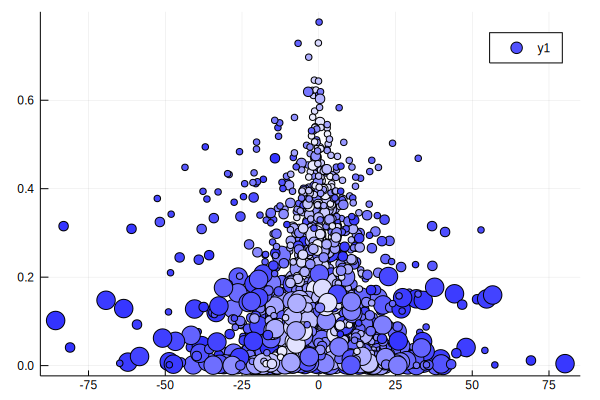

In [225]:
indexes = [idx for idx in findall((t.lambda .> 0.2) .* (t.lambda .< 0.95) .* (t.n1 .!= 1) .* (t.nm .<= 3) .* (t.prob .> 0.0001))]
myplot=plot()
scatter!(t.closeness[indexes],t.prob[indexes],color=t.colors[indexes],markersize = 10.0 ./ (0.01 .+t.nm[indexes]))

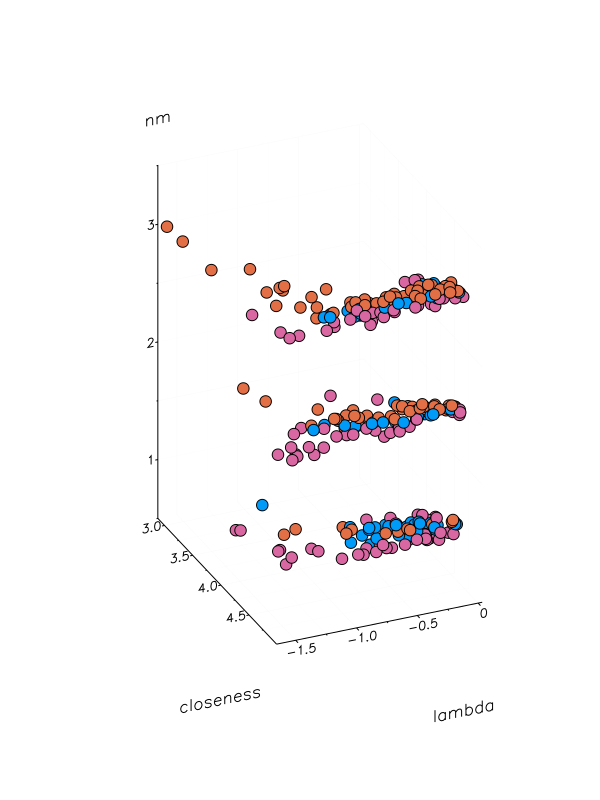

In [59]:
indexes = [idx for idx in findall((tmc.lambda .> 0.2) .* (tmc.lambda .< 0.99) .* (tmc.n1 .!= 1) .* (tmc.nm .<= 3) .* (tmc.prob .> 0.0001) .* (tmc.size .== 8)) ]
myplot=plot()
scatter!([log(elt+100) for elt in tmc.closeness[indexes]],[log(elt) for elt in tmc.lambda[indexes]],tmc.nm[indexes],color=tmc.colorsclassifier[indexes],markersize = 6,camera=(60,40),leg=false,xlabel="closeness",ylabel="lambda",zlabel="nm",aspect_ratio=2.0,size=(600,800,700))

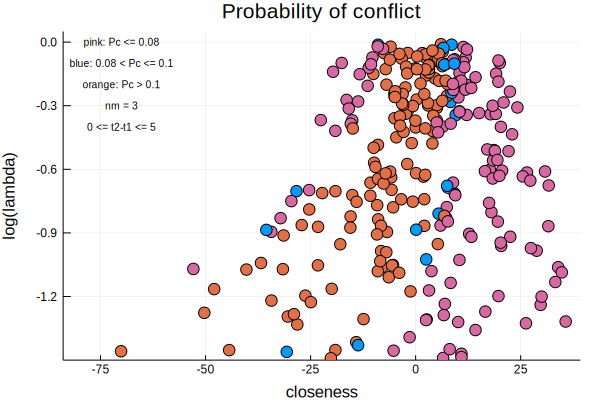

In [145]:
indexes = [idx for idx in findall((tmc.lambda .> 0.11) .* (tmc.lambda .< 0.99) .* (tmc.n1 .!= 1) .* (tmc.nm .== 2) .* (tmc.prob .> 0.0001) .* (tmc.size .== 8)) ]
myplot=plot()
scatter!([elt for elt in tmc.closeness[indexes]],[log(elt) for elt in tmc.lambda[indexes]],color=tmc.colorsclassifier[indexes],markersize = 6,camera=(60,40),leg=false,xlabel="closeness",ylabel="log(lambda)",ylims=(-1.5,0.05),title="Probability of conflict")
annotate!(-70,0,text("pink: Pc <= 0.08",7)) 
annotate!(-70,-0.1,text("blue: 0.08 < Pc <= 0.1",7))
annotate!(-70,-0.2,text("orange: Pc > 0.1",7))
annotate!(-70,-0.3,text("nm = 3",7))
annotate!(-70,-0.4,text("0 <= t2-t1 <= 5",7))

In [144]:
tmc[indexes,:]

,n1,n2,t1,t2,nm,lambda,prob,closeness,colors,colorsclassifier,size
,Int64,Int64,Float64,Float64,Int64,Float64,Any,Float64,RGB…,Int64,Float64
1,14,1,4.97258,8.68425,2,0.691424,0.0705333,-15.0901,"RGB{Float64}(0.691424,0.691424,1.0)",0,8.0
2,14,2,2.38653,4.58126,2,0.755758,0.0352667,-13.6834,"RGB{Float64}(0.755758,0.755758,1.0)",0,8.0
3,14,5,6.32519,9.77305,2,0.485979,0.327067,-15.0715,"RGB{Float64}(0.485979,0.485979,1.0)",2,8.0
4,10,10,2.08215,5.49477,2,0.856598,0.234267,3.41262,"RGB{Float64}(0.856598,0.856598,1.0)",2,8.0
5,5,20,5.30912,8.4873,2,0.543199,0.0002,30.7924,"RGB{Float64}(0.543199,0.543199,1.0)",0,8.0
6,12,9,2.8722,5.20183,2,0.724904,0.325133,-1.80885,"RGB{Float64}(0.724904,0.724904,1.0)",2,8.0
7,6,8,4.96863,7.09257,2,0.691801,0.176067,5.01495,"RGB{Float64}(0.691801,0.691801,1.0)",2,8.0
8,6,12,4.28113,7.93585,2,0.265459,0.000133333,26.2571,"RGB{Float64}(0.265459,0.265459,1.0)",0,8.0
9,10,14,4.15339,7.13097,2,0.75378,0.0982,8.28417,"RGB{Float64}(0.75378,0.75378,1.0)",1,8.0


In [370]:
vectors = DataFrame(t1mt2 = tmc.t1 .- tmc.t2, nm = tmc.nm, lmbda = tmc.lambda,closeness=tmc.closeness,prob=tmc.prob,label = tmc.prob .> 0.08)

,t1mt2,nm,lmbda,closeness,prob,label
,Float64,Int64,Float64,Float64,Any,Bool
1,-0.276162,8,0.341995,49.9845,0.0393333,false
2,6.6977,10,0.565916,23.3421,0.810333,true
3,6.00569,4,0.951302,-18.62,0.00613333,false
4,-3.12935,9,0.250757,-28.7741,0.768667,true
5,3.05455,2,0.480718,-30.0974,0.0002,false
6,7.99201,7,0.55822,-6.2006,0.102067,true
7,-0.250887,6,0.279898,7.39634,0.683133,true
8,-3.56369,10,0.83545,1.16977,0.8942,true
9,-3.03326,6,0.357424,-33.3381,0.6184,true


In [226]:
using CSV

┌ Info: Recompiling stale cache file /home/peltzer/.julia/compiled/v1.0/CSV/HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1190


In [380]:
CSV.write("pruned_testing_data.csv",pruned_testing_vecs)

"pruned_testing_data.csv"